In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
np.complex = complex

In [111]:
import torch
from torch import nn
from torchvision.transforms import v2 as tfs
import torch.nn.functional as F
from tqdm import tqdm
import librosa
import soundfile as sf
import os

In [3]:
sns.set(rc={"figure.figsize":(9,6)})

In [4]:
data = pd.read_csv("train.csv")

In [5]:
data.head()

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ


### Sound preprocessing test

In [6]:
audio_path = 'morse_dataset/morse_dataset/1.opus'
y, sr = librosa.load(audio_path, sr=8000)

In [7]:
y_trimmed, _ = librosa.effects.trim(y, top_db=30)

In [8]:
y_normalized = y_trimmed / np.max(np.abs(y_trimmed))

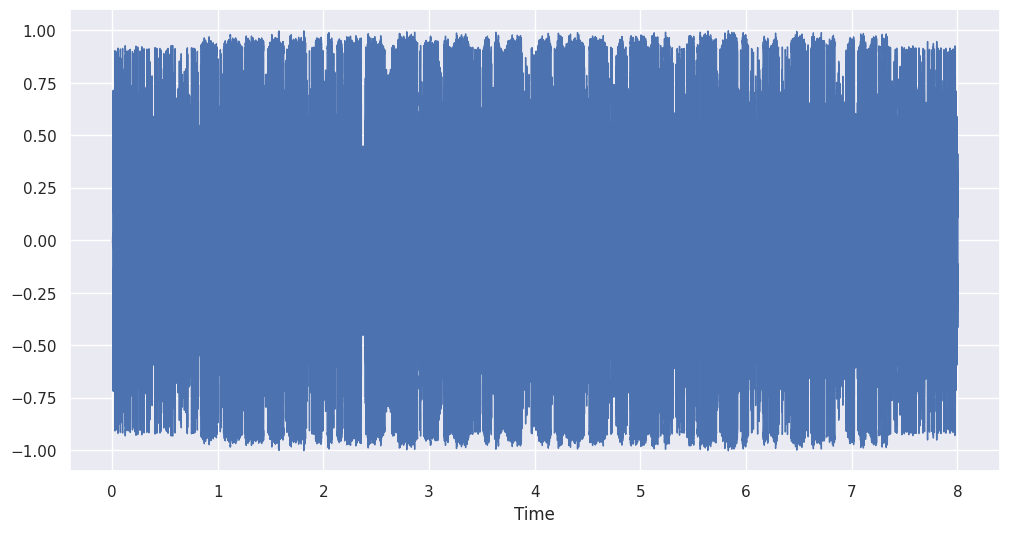

In [9]:
import librosa.display

plt.figure().set_figwidth(12)
librosa.display.waveshow(y_normalized, sr=sr)

### Preprocessing

In [27]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=8000)
    y, _ = librosa.effects.trim(y, top_db=30)
    y = y / np.max(np.abs(y))

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=64)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max,top_db=40)
    return mel_spec_db
    
def show_melspect(mel_spec):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=8000, hop_length=128, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Мел-спектрограмма')
    plt.tight_layout()
    plt.show()

In [64]:
mel = extract_features("morse_dataset/morse_dataset/29865.opus")
tns = torch.from_numpy(mel)
mn = tns.min()
mx = tns.max()

tns_norm = (tns - mn) / (mx - mn + 1e-8) 
tns_scaled =  F.relu(tns_norm * 1.75 - 1)
print(tns_scaled.size())

torch.Size([64, 501])


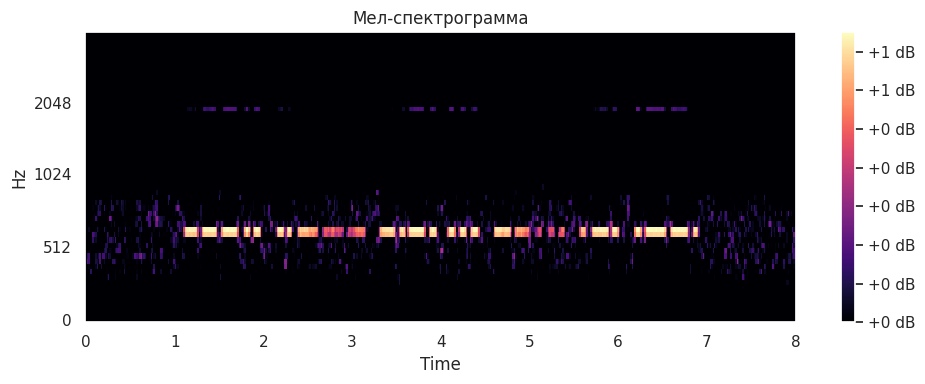

In [61]:
show_melspect(tns_scaled.numpy())

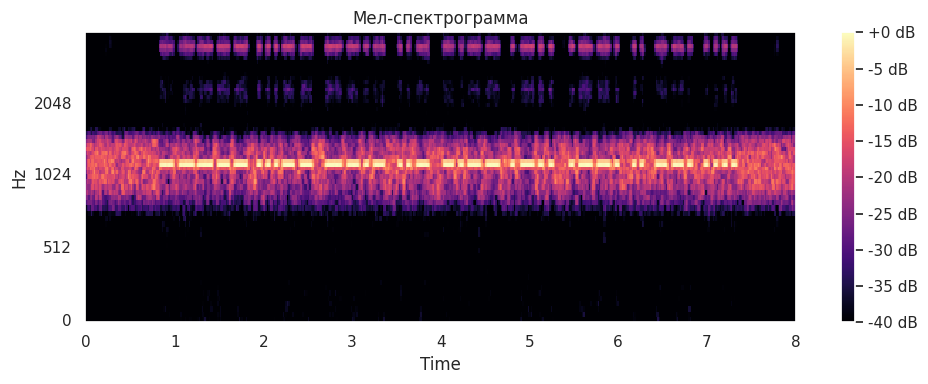

In [29]:
show_melspect(mel)

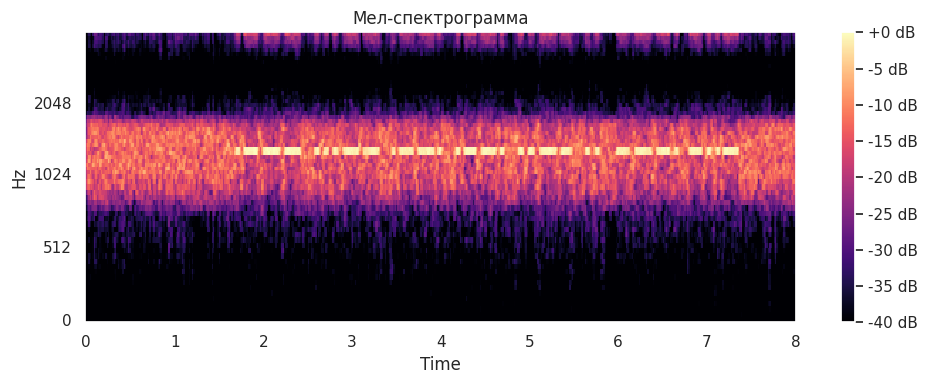

(64, 501)

In [23]:
mel5 = extract_features("morse_dataset/morse_dataset/27762.opus")
show_melspect(mel5)
mel5.shape

### Char dict

In [14]:
all_text = "".join(data["message"].astype(str).tolist())
unique_chars = sorted(set(all_text))
blank_token = "_"
vocab = [blank_token] + unique_chars
char2idx = {c: i for i, c in enumerate(vocab)}
idx2char = {i: c for c, i in char2idx.items()}

In [66]:
# Extract Tensor
def extract_mel_spectrogram(path, sr=8000, n_mels=64, n_fft=512, hop_length=128):
    y, _ = librosa.load(path, sr=sr)

    y, _ = librosa.effects.trim(y, top_db=30)
    y = y / (np.max(np.abs(y)) + 1e-6)
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    mel_db = librosa.power_to_db(mel, ref=np.max, top_db=40)
    print(torch.from_numpy(mel_db).float().size())
    return torch.from_numpy(mel_db).unsqueeze(0).float()

import time

# Замер времени для одного аудиофайла
start = time.time()
spec = extract_mel_spectrogram("morse_dataset/morse_dataset/449.opus")
print(f"Mel-spectrogram time: {time.time() - start:.3f}s")

torch.Size([64, 501])
Mel-spectrogram time: 0.066s


In [161]:
def extract_mel_spectrogram(
    path, sr=8000, n_mels=64, n_fft=512, hop_length=128, verbose=False
):
    y, _ = librosa.load(path, sr=sr)

    y, _ = librosa.effects.trim(y, top_db=30)
    y = y / (np.max(np.abs(y)) + 1e-6)

    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    mel_db = librosa.power_to_db(mel, ref=np.max, top_db=40)

    mel_tensor = torch.from_numpy(mel_db).float()
    mel_min, mel_max = mel_tensor.min(), mel_tensor.max()
    mel_tensor = (mel_tensor - mel_min) / (mel_max - mel_min + 1e-8)  # [0, 1]
    mel_tensor = mel_tensor * 2 - 1  # [-1, 1]

    mel_tensor = mel_tensor.unsqueeze(0)

    if verbose:
        print(f"Mel-spectrogram shape: {mel_tensor.shape}")
    
    return mel_tensor  # torch.Size([1, 64, T])

In [162]:
def crop_mel_band_fixed(mel_tensor, target_height=30):
    """
    mel_tensor: torch.Tensor формы [1, n_mels, T]
    target_height: сколько частот оставить (должно быть не больше n_mels)

    Возвращает: [1, target_height, T]
    """
    mel = mel_tensor.squeeze(0)  # [n_mels, T]
    n_mels = mel.shape[0]

    # Сумма по времени → максимальная активная частота
    energy = mel.sum(dim=1)
    max_idx = torch.argmax(energy).item()

    half = target_height // 2
    start = max(0, max_idx - half)
    end = start + target_height

    # Если вышли за границу в верх
    if end > n_mels:
        end = n_mels
        start = max(0, end - target_height)

    mel_cropped = mel[start:end, :]  # [target_height, T]
    return mel_cropped.unsqueeze(0)  # [1, target_height, T]


Mel-spectrogram shape: torch.Size([1, 64, 501])
Mel-spectrogram time: 0.026s
torch.Size([1, 61, 501])


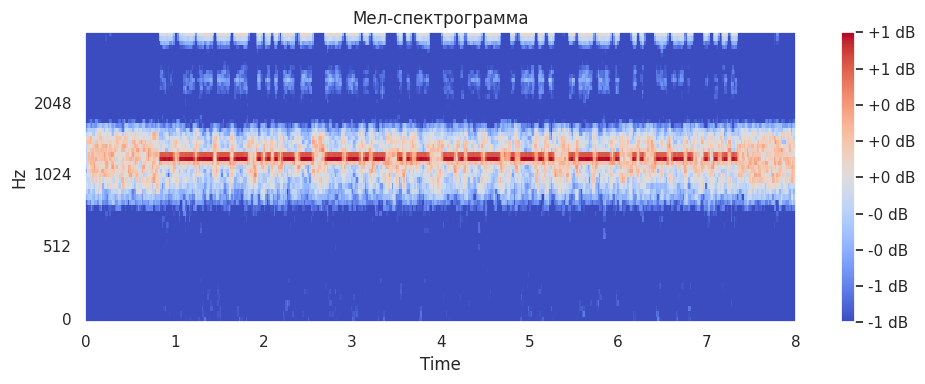

In [163]:
start = time.time()

spec = extract_mel_spectrogram("morse_dataset/morse_dataset/1.opus", verbose=True)
spec_croped = crop_mel_band(spec, 30)
print(f"Mel-spectrogram time: {time.time() - start:.3f}s")
print(spec_croped.shape)
show_melspect(spec_croped.squeeze(0).numpy())

In [249]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class MorseDataset(Dataset):
    def __init__(self, csv_path, audio_dir,target_height=32):
        self.df = pd.read_csv(csv_path)
        self.audio_dir = audio_dir
        self.target_height = target_height 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row["id"]
        text = row["message"]
        spec = extract_mel_spectrogram(os.path.join(self.audio_dir, fname))
        spec_croped = crop_mel_band_fixed(spec, target_height=self.target_height)
        target = torch.tensor([char2idx[c] for c in text], dtype=torch.long)
        return spec_croped, target

In [102]:
def collate_fn(batch):
    specs, targets = zip(*batch)
    # длины по времени
    spec_lens = torch.tensor([s.shape[-1] for s in specs], dtype=torch.long)
    # паддим спектрограммы до max T
    # сначала меняем shape [1, n_mels, T] → [T, n_mels] для pad_sequence
    specs_seq = [s.squeeze(0).transpose(0,1) for s in specs]
    specs_padded = pad_sequence(specs_seq, batch_first=True)  
    # обратно в [B, 1, n_mels, T_max]
    specs_padded = specs_padded.transpose(1,2).unsqueeze(1)

    # таргеты
    target_lens = torch.tensor([t.numel() for t in targets], dtype=torch.long)
    targets_concat = torch.cat(targets)
    return specs_padded, spec_lens, targets_concat, target_lens

In [213]:
class MorseCTCModel(nn.Module):
    def __init__(self, n_mels=30, num_classes=len(vocab), lstm_hidden=128, lstm_layers=2):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1)),  # [B, 32, 30, T]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),                      # [B, 32, 15, T//2]
            nn.Conv2d(32, 64, kernel_size=(3, 3),padding=(1,1)),                   # [B, 64, 13, T//2]
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((None, 50))                     # Сохраняет частотные оси
        )
        self.lstm = nn.LSTM(
            input_size=64,              # Новый input_size
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.3 if lstm_layers > 1 else 0
        )
        self.classifier = nn.Linear(lstm_hidden * 2, num_classes)

    
    def forward(self, x):
        """
        x: [B, 1, 30, T]
        """
        B = x.size(0)
        x_sh = x[5].squeeze(0)
        print(x_sh.shape)
        show_melspect(x_sh.detach().numpy())
        
        x = self.cnn(x)# → [B, 64, 1, T]
        
        x_sh = x[5][0]
        print(x_sh.shape)
        show_melspect(x_sh.detach().numpy())
        #x = x.squeeze(2)         # → [B, 64, T]
        #x = x.permute(0, 2, 1)   # → [B, T, 64]
    
        #x, _ = self.lstm(x)      # → [B, T, 2*hidden]
        #x = self.classifier(x)   # → [B, T, num_classes]
        return x.log_softmax(dim=-1)

torch.Size([30, 501])


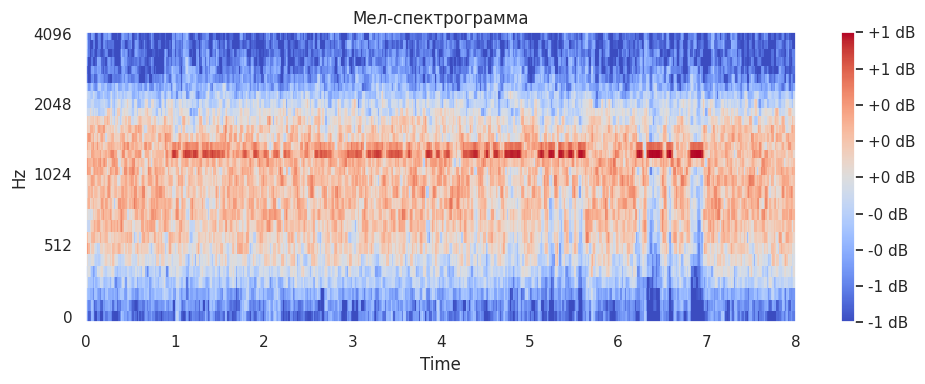

torch.Size([15, 50])


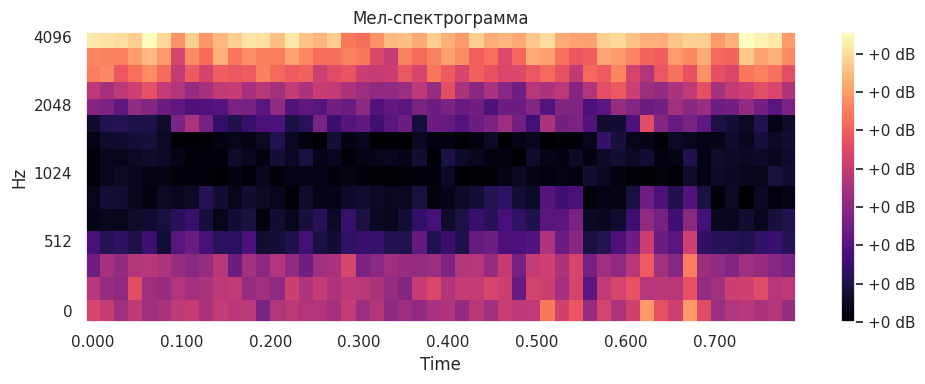

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [214]:
ds = MorseDataset("train.csv", "morse_dataset/morse_dataset/",)
loader = DataLoader(ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
model = MorseCTCModel()
criterion = nn.CTCLoss(blank=char2idx[blank_token], zero_infinity=True)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.001, 
    weight_decay=1e-4
)
# тестовый прогон
start = time.time()
specs, spec_lens, targets, target_lens = next(iter(loader))
#print(specs.shape)
out = model(specs)           # [B, T', C]
out = out.permute(1,0,2)# → [T', B, C]
#print(out.shape)
loss = criterion(out, targets, spec_lens // 4, target_lens)
print(f"all: {time.time() - start:.3f}s")
print("CTC loss:", loss.item())

  0%|                                                  | 0/1875 [00:00<?, ?it/s]

torch.Size([30, 501])


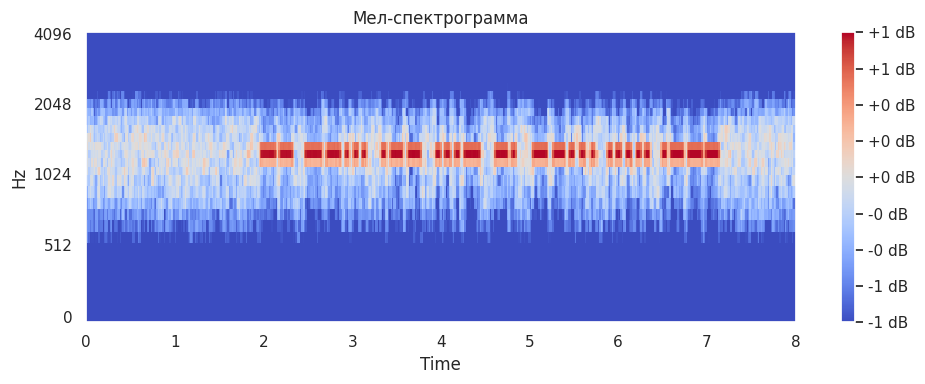

torch.Size([13, 50])


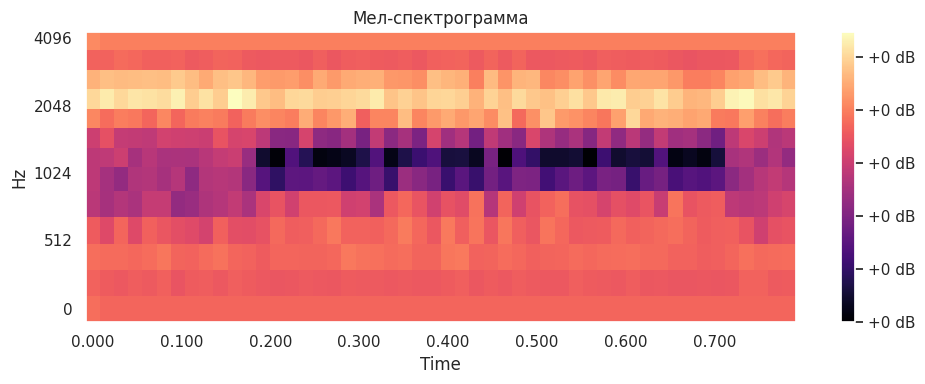

  0%|                                                  | 0/1875 [00:01<?, ?it/s]


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [199]:
epochs = 10
train_losses = []
model.train()
for epoch in range(epochs):
    loss_mean = 0
    lm_count = 0
    t_loader = tqdm(loader,leave=True)
    for specs, slens, targets, tlens in t_loader:
        logits = model(specs).permute(1, 0, 2)

        loss = criterion(logits, targets, slens, tlens)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        lm_count += 1
        
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        t_loader.set_description(f"Epoch [{epoch+1}/{epochs}], loss_mean={loss_mean:.3f}")

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")
plt.title("Training Loss")
plt.show()

In [515]:
# class ExpActivation(nn.Module):
#     def __init__(self, scale=0.3, threshold=65.0):
#         super().__init__()
#         self.scale = scale
#         self.threshold = threshold

#     def forward(self, x):
#         return x * torch.exp(self.scale * (x - self.threshold))

class MorseCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 1))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 5), padding=(1, 2)),  # [B, 64, 16, T]
            nn.BatchNorm2d(32),
            nn.ReLU6(),
            nn.MaxPool2d((1, 2))  # Уменьшаем время: [B, 64, 16, T//2]
        )
        
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d((16, 1)),
            nn.Conv2d(32, 32, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        plot_activations(x, "После Conv1")
        attn = self.attention(x)
        plot_activations(attn, "Attention")
        x = torch.exp(x * attn + 5)
        plot_activations(x, "После Attention")
        x = self.conv2(x)
        plot_activations(x, "После Conv2")
        print(x.shape)
        return x.permute(0, 3, 2, 1).flatten(2)

In [516]:
class MorseCTCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = MorseCNN()
        self.lstm = nn.LSTM(
            input_size=16*64,  # 1920
            hidden_size=128,
            num_layers=1,  # Упрощаем LSTM
            bidirectional=True
        )
        self.classifier = nn.Linear(256, len(vocab))

    def forward(self, x):
        x = self.cnn(x)  # [B, T, 1024]
        x, _ = self.lstm(x)  # [B, T, 256]
        print("apres ltsm : ", x.shape)
        return self.classifier(x).log_softmax(dim=-1)

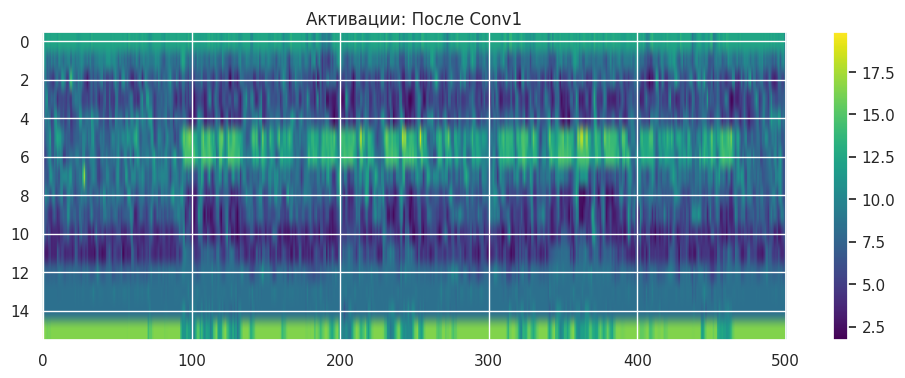

RuntimeError: Given groups=1, weight of size [32, 32, 1, 1], expected input[32, 16, 16, 1] to have 32 channels, but got 16 channels instead

In [517]:

modelcnn = MorseCNN()
test.shape
out = modelcnn(test)
print(out.shape)

In [487]:
ds = MorseDataset("train.csv", "morse_dataset/morse_dataset/")
loader = DataLoader(ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
specs, spec_lens, targets, target_lens = next(iter(loader))
test = specs

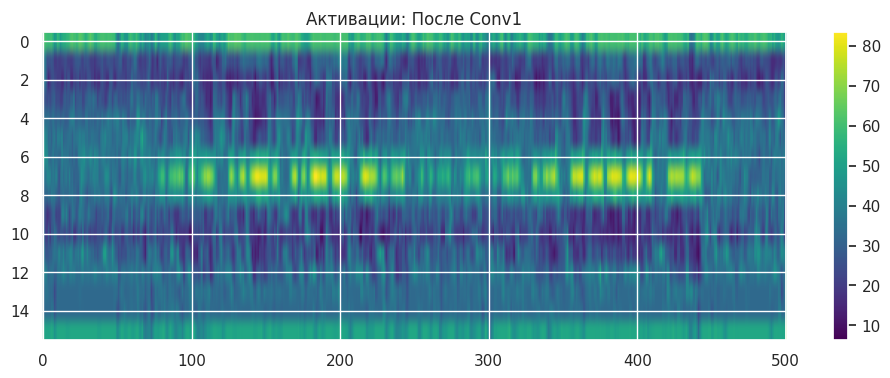

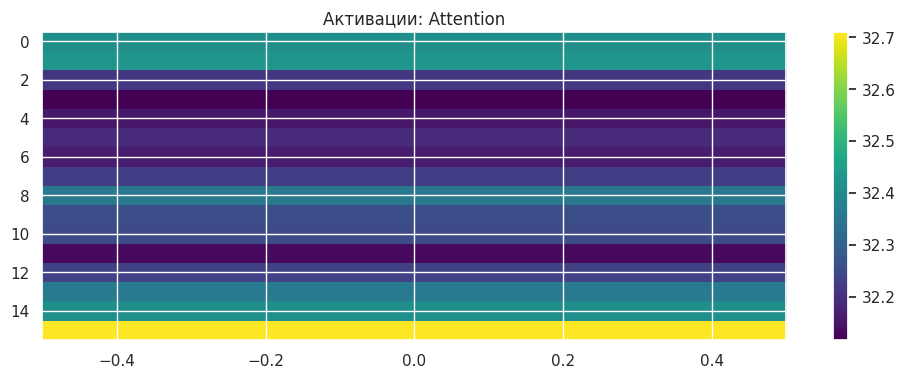

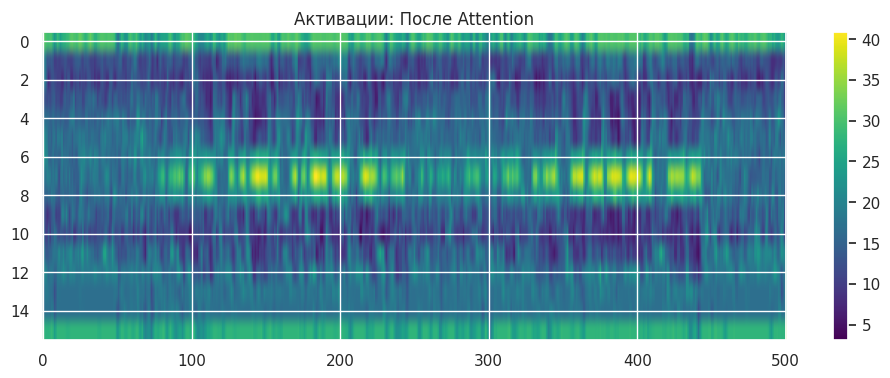

torch.Size([32, 64, 16, 501])
apres ltsm :  torch.Size([32, 501, 256])


In [450]:
model = MorseCTCModel()
res = model(test)

In [351]:
import matplotlib.pyplot as plt

def plot_activations(x, layer_name):
    plt.figure(figsize=(12, 4))
    plt.imshow(x[0].detach().sum(dim=0).cpu(), aspect='auto', cmap='viridis')
    plt.title(f"Активации: {layer_name}")
    plt.colorbar()
    plt.show()
